In [274]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.distributions as D
import torch.nn.functional as F

from scipy.stats import mode
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from models.bbb import BayesLinear

In [103]:
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, o_dim, h_dim,
                 h_act=nn.ELU):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, o_dim)
        self.h_act = h_act()
    
    def forward(self, x):
        x = self.h_act(self.fc1(x))
        x = self.h_act(self.fc2(x))
        return self.fc3(x)

In [78]:
class BayesNet(nn.Module):# T.B.U.
    def __init__(self, in_dim, o_dim, h_dim,
                 h_act=nn.ELU, noise_level=None):
        super(BayesNet, self).__init__()
        self.fc1 = BayesLinear(in_dim, h_dim)
        self.fc2 = BayesLinear(h_dim, h_dim)
        if noise_level is None:
            self.fc3 = BayesLinear(h_dim, 2*o_dim)
            self.noise_level = noise_level
        else:
            self.fc3 = BayesLinear(h_dim, o_dim)
            self.noise_level = nn.Parameter(torch.as_tensor(noise_level))
        self.h_act = h_act()
        self.o_dim = o_dim

    def forward(self, x):
        x = self.h_act(self.fc1(x))
        x = self.h_act(self.fc2(x))
        if self.noise_level is None:
            mu, var = torch.split(self.fc3(x), self.o_dim, dim=1)
            var = F.softplus(var)
            return mu, var
        else:
            return self.fc3(x)

    def log_p(self):
        return self.fc1.log_p + self.fc2.log_p + self.fc3.log_p

    def log_q(self):
        return self.fc1.log_q + self.fc2.log_q + self.fc3.log_q

    def sample(self, input, samples, kl=False):
        outputs = torch.zeros(samples, input.shape[0], self.o_dim)
        if self.noise_level is None:
            uns = torch.zeros(samples, input.shape[0], self.o_dim)
        if kl:
            log_priors = torch.zeros(samples)
            log_var_posts = torch.zeros(samples)
        for i in range(samples):
            if self.noise_level is None:
                mu, var = self(input)
                outputs[i] = mu
                uns[i] = var.sqrt()
            else:
                outputs[i] = self(input)
            if kl:
                log_priors[i] = self.log_p()
                log_var_posts[i] = self.log_q()
        mu = outputs.mean(0)
        un_model = outputs.std(0)
        if self.noise_level is None:
            un_noise = uns.mean(0)
        else:
            un_noise = self.noise_level
        if kl:
            return mu, un_model+un_noise, log_priors.mean(), log_var_posts.mean()
        return mu, un_model+un_noise

In [247]:
class MCDropout(nn.Module):
    def __init__(self, in_dim, o_dim, h_dim,
                 h_act=nn.ELU, dropout=0.5,
                 noise_level=None, agent=True):
        super(MCDropout, self).__init__()
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)
        if noise_level is None:
            self.fc3 = nn.Linear(h_dim, 2*o_dim)
            self.noise_level = noise_level
        else:
            self.fc3 = nn.Linear(h_dim, o_dim)
            self.noise_level = nn.Parameter(torch.as_tensor(noise_level))
        self.h_act = h_act()
        self.p = dropout
        self.o_dim = o_dim
        self.agent = agent
    
    def forward(self, x):
        x = self.h_act(self.fc1(x))
        x = F.dropout(x, p=self.p, training=self.agent)
        x = self.h_act(self.fc2(x))
        x = F.dropout(x, p=self.p, training=self.agent)
        if self.noise_level is None:
            mu, var = torch.split(self.fc3(x), self.o_dim, dim=1)
            var = F.softplus(var)
            return mu, var
        else:
            return self.fc3(x)
    
    def sample(self, input, samples):
        outputs = torch.zeros(samples, input.shape[0], self.o_dim)
        if self.noise_level is None:
            uns = torch.zeros(samples, input.shape[0], self.o_dim)
        for i in range(samples):
            if self.noise_level is None:
                mu, var = self(input)
                outputs[i] = mu
                uns[i] = var.sqrt()
            else:
                outputs[i] = self(input)
        mu = outputs.mean(0)
        un_model = outputs.std(0)
        if self.noise_level is None:
            un_noise = uns.mean(0)
        else:
            un_noise = self.noise_level
        return mu, un_model+un_noise

In [37]:
class H_MLP(nn.Module):
    def __init__(self, in_dim, o_dim, h_dim,
                 h_act=nn.ELU):
        super(H_MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, h_dim)
        self.fc3 = nn.Linear(h_dim, 2*o_dim)

        self.h_act = h_act()
        self.o_dim = o_dim

    def forward(self, x):
        x = self.h_act(self.fc1(x))
        x = self.h_act(self.fc2(x))
        mu, var = x = torch.split(self.fc3(x), self.o_dim, dim=1)
        var = F.softplus(var)
        return mu, var

class EnModel(nn.Module):
    def __init__(self, model=H_MLP, n_model=5, *args, **kwargs):
        super(EnModel, self).__init__()
        self.n_model = n_model
        self.heads = nn.ModuleList()
        for i in range(n_model):
            self.heads.append(model(*args, **kwargs))

    def forward(self, x):
        mu_list, var_list = [], []
        for head in self.heads:
            mu, var = head(x)
            mu_list.append(mu)
            var_list.append(var)
        mu_list = torch.stack(mu_list, dim=-1).squeeze()
        var_list = torch.stack(var_list, dim=-1).squeeze()
        mu_n = torch.mean(mu_list, axis=-1, keepdim=True)
        var_n = torch.mean(torch.pow(mu_list, 2)+var_list,
                           axis=-1, keepdim=True) - torch.pow(mu_n, 2)
        return mu_n, var_n

In [14]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, size: int):
        self.memory = deque(maxlen=size)

    def __len__(self):
        return len(self.memory)

    def push(self, ex):
        self.memory.append(ex)

    def sample(self, batch_size):
        return random.sample(self.memory, k=batch_size)


In [15]:
def get_batch(experiences):
    assert len(experiences[0]) == 5
    batch_state = torch.cat([ex[0] for ex in experiences], 0).float()
    batch_act = torch.as_tensor([ex[1] for ex in experiences]).unsqueeze(1)
    batch_reward = torch.as_tensor([ex[2] for ex in experiences]).unsqueeze(1)
    batch_next = torch.cat([ex[3] for ex in experiences], 0).float()
    batch_mask = 1 - torch.as_tensor([ex[4] for ex in experiences]).int().unsqueeze(1)
    return batch_state, batch_act, batch_reward, batch_next, batch_mask

In [248]:
class DQNAgent(nn.Module):
    def __init__(self, s_dim, a_dim, h_dim,
                 h_act=nn.ReLU, buffer_size=100000,
                 batch_size=32, lr=1e-4, gamma=0.95,
                 theta=0.01, *args, **kwargs):
        super(DQNAgent, self).__init__()
        self.q_net = SimpleMLP(in_dim=s_dim, o_dim=a_dim,
                               h_dim=h_dim, h_act=h_act)
        self.target_net = SimpleMLP(in_dim=s_dim, o_dim=a_dim,
                                    h_dim=h_dim, h_act=h_act)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.optimizer = Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.theta = theta

    def forward(self, x):
        return self.q_net(x)

    def save_memory(self, ex):
        self.buffer.push(ex)

    def train(self, k=1, max_norm=None):
        losses = []
        for _ in range(k):
            experiences = self.buffer.sample(self.batch_size)
            s, a, r, t, mask = get_batch(experiences)
            next_q = self.target_net(t).max(-1, keepdim=True)[0]
            target = r + self.gamma*mask*next_q.detach()
            pred = self.q_net(s).gather(-1, a)
            loss = F.mse_loss(pred, target)
            self.optimizer.zero_grad()
            loss.backward()
            if max_norm is not None:
                clip_grad_norm_(self.q_net.parameters(), max_norm)
            self.optimizer.step()
            losses.append(loss.item())
        self.target_update()
        return np.mean(losses)

    def train_start(self):
        return (len(self.buffer) >= self.batch_size)

    def target_update(self):
        for target, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target.data = (1-self.theta)*target.data + self.theta*param.data

In [249]:
class BootDQNAgent(nn.Module):
    def __init__(self, s_dim, a_dim, h_dim,
                 h_act=nn.ReLU, buffer_size=100000,
                 batch_size=32, lr=1e-4, gamma=0.95,
                 theta=0.01, n_model=5, *args, **kwargs):
        super(BootDQNAgent, self).__init__()
        q_list = [SimpleMLP(in_dim=s_dim, o_dim=a_dim,
                            h_dim=h_dim, h_act=h_act)
                  for _ in range(n_model)]
        target_list = [SimpleMLP(in_dim=s_dim, o_dim=a_dim,
                                 h_dim=h_dim, h_act=h_act)
                       for _ in range(n_model)]
        self.q_nets = nn.ModuleList(q_list)
        self.target_nets = nn.ModuleList(target_list)
        self.target_nets.load_state_dict(self.q_nets.state_dict())
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.optimizers = [Adam(q_net.parameters(), lr=lr)
                           for q_net in self.q_nets]
        self.gamma = gamma
        self.theta = theta
        self.n_model = n_model
        self.current_head = None

    def forward(self, x):
        if self.training:
            return self.q_nets[self.current_head](x)
        else:
            return torch.cat([q_net(x) for q_net in self.q_nets], dim=0)

    def save_memory(self, ex):
        self.buffer.push(ex)

    def train(self, k=1, max_norm=None):
        losses = []
        for _ in range(k):
            for m, q_net in enumerate(self.q_nets):
                experiences = self.buffer.sample(self.batch_size)
                s, a, r, t, mask = get_batch(experiences)
                next_q = self.target_nets[m](t).max(-1, keepdim=True)[0]
                target = r + self.gamma*mask*next_q.detach()
                pred = q_net(s).gather(-1, a)
                loss = F.mse_loss(pred, target)
                self.optimizers[m].zero_grad()
                loss.backward()
                if max_norm is not None:
                    clip_grad_norm_(q_net.parameters(), max_norm)
                self.optimizers[m].step()
                losses.append(loss.item())
        self.target_update()
        return np.mean(losses)

    def train_start(self):
        return (len(self.buffer) >= self.batch_size)

    def target_update(self):
        for target, param in zip(self.target_nets.parameters(), self.q_nets.parameters()):
            target.data = (1-self.theta)*target.data + self.theta*param.data

In [250]:
class B3DQNAgent(nn.Module):
    def __init__(self, s_dim, a_dim, h_dim,
                 h_act=nn.ReLU, buffer_size=100000,
                 batch_size=32, lr=1e-4, gamma=0.95,
                 theta=0.01, noise_level=None,
                 n_sample=5, *args, **kwargs):
        super(B3DQNAgent, self).__init__()
        self.q_net = BayesNet(in_dim=s_dim, o_dim=a_dim,
                              h_dim=h_dim, h_act=h_act,
                              noise_level=noise_level)
        self.target_net = BayesNet(in_dim=s_dim, o_dim=a_dim,
                                   h_dim=h_dim, h_act=h_act,
                                   noise_level=noise_level)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.optimizer = Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.theta = theta

        self.noise_level = noise_level
        self.n_sample = n_sample

    def forward(self, x):
        if self.training:
            self.q_net.train()
            return self.q_net.sample(x, self.n_sample)
        else:
            self.q_net.eval()
            return self.q_net(x)

    def save_memory(self, ex):
        self.buffer.push(ex)

    def train(self, lamb, k=1, max_norm=None):
        losses = []
        self.q_net.train()
        for _ in range(k):
            experiences = self.buffer.sample(self.batch_size)
            s, a, r, t, mask = get_batch(experiences)
            self.target_net.eval()
            next_mu, _ = self.target_net(t)
            next_q = next_mu.max(-1, keepdim=True)[0]
            target = r + self.gamma*mask*next_q.detach()
            preds, uns, log_prior, log_var_post = self.q_net.sample(s, self.n_sample, True)
            pred = preds.gather(-1, a)
            un = uns.gather(-1, a)
            ll = D.Normal(pred, un).log_prob(target).mean()
            loss = lamb*(log_var_post - log_prior) - ll
            self.optimizer.zero_grad()
            loss.backward()
            if max_norm is not None:
                clip_grad_norm_(self.q_net.parameters(), max_norm)
            self.optimizer.step()
            losses.append(loss.item())
        self.target_update()
        return np.mean(losses)

    def train_start(self):
        return (len(self.buffer) >= self.batch_size)

    def target_update(self):
        self.target_net.train()
        for target, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target.data = (1-self.theta)*target.data + self.theta*param.data


In [251]:
class DropDQNAgent(nn.Module):
    def __init__(self, s_dim, a_dim, h_dim,
                 h_act=nn.ReLU, buffer_size=100000,
                 batch_size=32, lr=1e-4, gamma=0.95,
                 theta=0.01, dropout=0.5, weight_decay=0.1,
                 noise_level=None, n_sample=5,
                 *args, **kwargs):
        super(DropDQNAgent, self).__init__()
        self.q_net = MCDropout(in_dim=s_dim, o_dim=a_dim, h_dim=h_dim,
                               h_act=h_act, dropout=dropout,
                               noise_level=noise_level)
        self.target_net = MCDropout(in_dim=s_dim, o_dim=a_dim, h_dim=h_dim,
                                    h_act=h_act, dropout=dropout,
                                    noise_level=noise_level, agent=False)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.optimizer = Adam(self.q_net.parameters(), lr=lr,
                              weight_decay=weight_decay)
        self.gamma = gamma
        self.theta = theta
        
        self.noise_level = noise_level
        self.n_sample = n_sample

    # T.B.U.
    def forward(self, x):
        if self.training:
            self.q_net.agent = True
            return self.q_net.sample(x, self.n_sample)
        else:
            self.q_net.agent = False
            return self.q_net(x)

    def save_memory(self, ex):
        self.buffer.push(ex)

    # T.B.U.
    def train(self, k=1, max_norm=None):
        losses = []
        self.q_net.agent = True
        for _ in range(k):
            experiences = self.buffer.sample(self.batch_size)
            s, a, r, t, mask = get_batch(experiences)
            next_mu, _ = self.target_net(t)
            next_q = next_mu.max(-1, keepdim=True)[0]
            target = r + self.gamma*mask*next_q.detach()
            pred_mu, pred_un = self.q_net.sample(s, self.n_sample)
            pred = pred_mu.gather(-1, a)
            un = pred_un.gather(-1, a)
            loss = -1. * D.Normal(pred, un).log_prob(target).mean()
            self.optimizer.zero_grad()
            loss.backward()
            if max_norm is not None:
                clip_grad_norm_(self.q_net.parameters(), max_norm)
            self.optimizer.step()
            losses.append(loss.item())
        self.target_update()
        return np.mean(losses)

    def train_start(self):
        return (len(self.buffer) >= self.batch_size)

    def target_update(self):
        for target, param in zip(self.target_net.parameters(), self.q_net.parameters()):
            target.data = (1-self.theta)*target.data + self.theta*param.data

In [252]:
class EnDQNAgent(nn.Module):
    def __init__(self, s_dim, a_dim, h_dim,
                 h_act=nn.ReLU, buffer_size=100000,
                 batch_size=32, lr=1e-4, gamma=0.95,
                 theta=0.01, n_model=5,
                 *args, **kwargs):
        super(EnDQNAgent, self).__init__()
        self.q_nets = EnModel(in_dim=s_dim, o_dim=a_dim, h_dim=h_dim,
                              h_act=h_act, n_model=5)
        self.target_nets = EnModel(in_dim=s_dim, o_dim=a_dim, h_dim=h_dim,
                                   h_act=h_act, n_model=5)
        self.target_nets.load_state_dict(self.q_nets.state_dict())
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        
        self.optimizers = [Adam(head.parameters(), lr=lr)
                           for head
                           in self.q_nets.heads]
        self.gamma = gamma
        self.theta = theta
        self.n_model = n_model

    # T.B.U.
    def forward(self, x):
        return self.q_nets(x)

    def save_memory(self, ex):
        self.buffer.push(ex)

    # T.B.U.
    def train(self, k=1, max_norm=None):
        losses = []
        for _ in range(k):
            for m in range(self.n_model):
                q_net = self.q_nets.heads[m]
                target_net = self.target_nets.heads[m]
                optimizer = self.optimizers[m]
                experiences = self.buffer.sample(self.batch_size)
                s, a, r, t, mask = get_batch(experiences)
                next_q_mu, _ = target_net(t)
                next_q = next_q_mu.max(-1, keepdim=True)[0]
                target = r + self.gamma*mask*next_q.detach()
                pred_mu, pred_var = q_net(s)
                pred = pred_mu.gather(-1, a)
                un = pred_var.sqrt().gather(-1, a)
                loss = -1. * D.Normal(pred, un).log_prob(target).mean()
                optimizer.zero_grad()
                loss.backward()
                if max_norm is not None:
                    clip_grad_norm_(q_net.parameters(), max_norm)
                optimizer.step()
                losses.append(loss.item())
        self.target_update()
        return np.mean(losses)

    def train_start(self):
        return (len(self.buffer) >= self.batch_size)

    def target_update(self):
        for target, param in zip(self.target_nets.parameters(), self.q_nets.parameters()):
            target.data = (1-self.theta)*target.data + self.theta*param.data

In [309]:
import gym
from gym.spaces import Discrete, Box

max_episode = 210
max_epi_step = 500
model_dir = 'experiments'
save_dir = 'rst'

rst_dict = {'DQN': None,
            'BootDQN': None,
            'Bayes by Backprop': None,
            'MC Dropout': None,
            'Deep Ensemble': None}

In [312]:
agent_name = 'DQN'
model_save_dir = os.path.join(model_dir, agent_name)
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

Simple_reward = []

for epoch in range(10):

    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim, 128, h_act=nn.ELU)
    print('\nEpoch %d\n' % (epoch+1))
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        reward_epi = []
        action = None

        for epi_step in range(max_epi_step):

            # make an action based on epsilon greedy
            if random.random() < epsilon:
                action = random.randint(0, action_dim - 1)
            else:
                action = agent(state)
                action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                loss = agent.train(k=4, max_norm=5.0)

            if done:
                break

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        for epi_step in range(max_epi_step):

            # make an greedy action
            action = agent(state)
            action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
            reward_epi.append(reward)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        env.close()
        reward_list.append(sum(reward_epi))
        
        if (episode+1) % 10 == 0:
            print('Episode:%d \t Rewards:%.1f \t Epsilon:%.2f' % (episode+1, reward_list[-1], epsilon))
    
    torch.save(agent.q_net.state_dict(),
               os.path.join(model_save_dir, '%d.pt' % epoch))
    Simple_reward.append(reward_list)

arr = np.asarray(Simple_reward)
np.save(os.path.join(save_dir, agent_name), arr)
rst_dict[agent_name] = arr


Epoch 1

Episode:10 	 Rewards:289.0 	 Epsilon:0.85
Episode:20 	 Rewards:42.0 	 Epsilon:0.80
Episode:30 	 Rewards:47.0 	 Epsilon:0.75
Episode:40 	 Rewards:64.0 	 Epsilon:0.70
Episode:50 	 Rewards:119.0 	 Epsilon:0.65
Episode:60 	 Rewards:236.0 	 Epsilon:0.60
Episode:70 	 Rewards:240.0 	 Epsilon:0.55
Episode:80 	 Rewards:228.0 	 Epsilon:0.50
Episode:90 	 Rewards:225.0 	 Epsilon:0.45
Episode:100 	 Rewards:237.0 	 Epsilon:0.40
Episode:110 	 Rewards:231.0 	 Epsilon:0.35
Episode:120 	 Rewards:336.0 	 Epsilon:0.30
Episode:130 	 Rewards:414.0 	 Epsilon:0.25
Episode:140 	 Rewards:224.0 	 Epsilon:0.20
Episode:150 	 Rewards:118.0 	 Epsilon:0.15
Episode:160 	 Rewards:114.0 	 Epsilon:0.10
Episode:170 	 Rewards:119.0 	 Epsilon:0.05
Episode:180 	 Rewards:116.0 	 Epsilon:0.01
Episode:190 	 Rewards:117.0 	 Epsilon:0.01
Episode:200 	 Rewards:100.0 	 Epsilon:0.01
Episode:210 	 Rewards:105.0 	 Epsilon:0.01

Epoch 2

Episode:10 	 Rewards:350.0 	 Epsilon:0.85
Episode:20 	 Rewards:57.0 	 Epsilon:0.80
Episod

Episode:30 	 Rewards:42.0 	 Epsilon:0.75
Episode:40 	 Rewards:34.0 	 Epsilon:0.70
Episode:50 	 Rewards:190.0 	 Epsilon:0.65
Episode:60 	 Rewards:209.0 	 Epsilon:0.60
Episode:70 	 Rewards:261.0 	 Epsilon:0.55
Episode:80 	 Rewards:344.0 	 Epsilon:0.50
Episode:90 	 Rewards:500.0 	 Epsilon:0.45
Episode:100 	 Rewards:267.0 	 Epsilon:0.40
Episode:110 	 Rewards:367.0 	 Epsilon:0.35
Episode:120 	 Rewards:464.0 	 Epsilon:0.30
Episode:130 	 Rewards:500.0 	 Epsilon:0.25
Episode:140 	 Rewards:500.0 	 Epsilon:0.20
Episode:150 	 Rewards:209.0 	 Epsilon:0.15
Episode:160 	 Rewards:150.0 	 Epsilon:0.10
Episode:170 	 Rewards:125.0 	 Epsilon:0.05
Episode:180 	 Rewards:500.0 	 Epsilon:0.01
Episode:190 	 Rewards:196.0 	 Epsilon:0.01
Episode:200 	 Rewards:215.0 	 Epsilon:0.01
Episode:210 	 Rewards:122.0 	 Epsilon:0.01


In [313]:
agent_name = 'BootDQN'
model_save_dir = os.path.join(model_dir, agent_name)
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

Boot_reward = []

for epoch in range(10):

    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = BootDQNAgent(state_dim, action_dim, 128, h_act=nn.ELU)
    print('\nEpoch %d\n' % (epoch+1))
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        reward_epi = []
        action = None

        for epi_step in range(max_epi_step):
            agent.current_head = np.random.randint(agent.n_model)

            # make an action based on epsilon greedy
            if random.random() < epsilon:
                action = random.randint(0, action_dim - 1)
            else:
                action = agent(state)
                action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                loss = agent.train(k=4, max_norm=5.0)

            if done:
                break
        
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        for epi_step in range(max_epi_step):

            # make an greedy action
            qvalues = agent(state)
            actions = torch.argmax(qvalues, dim=1)
            action = actions.mode().values.item()

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
            reward_epi.append(reward)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        env.close()
        reward_list.append(sum(reward_epi))

        if (episode+1) % 10 == 0:
            print('Episode:%d \t Rewards:%.1f \t Epsilon:%.2f' % (episode+1, reward_list[-1], epsilon))

    torch.save(agent.q_nets.state_dict(),
               os.path.join(model_save_dir, '%d.pt' % epoch))
    Boot_reward.append(reward_list)

arr = np.asarray(Boot_reward)
np.save(os.path.join(save_dir, agent_name), arr)
rst_dict[agent_name] = arr


Epoch 1

Episode:10 	 Rewards:12.0 	 Epsilon:0.85
Episode:20 	 Rewards:42.0 	 Epsilon:0.80
Episode:30 	 Rewards:44.0 	 Epsilon:0.75
Episode:40 	 Rewards:132.0 	 Epsilon:0.70
Episode:50 	 Rewards:341.0 	 Epsilon:0.65
Episode:60 	 Rewards:192.0 	 Epsilon:0.60
Episode:70 	 Rewards:226.0 	 Epsilon:0.55
Episode:80 	 Rewards:189.0 	 Epsilon:0.50
Episode:90 	 Rewards:176.0 	 Epsilon:0.45
Episode:100 	 Rewards:243.0 	 Epsilon:0.40
Episode:110 	 Rewards:227.0 	 Epsilon:0.35
Episode:120 	 Rewards:227.0 	 Epsilon:0.30
Episode:130 	 Rewards:191.0 	 Epsilon:0.25
Episode:140 	 Rewards:189.0 	 Epsilon:0.20
Episode:150 	 Rewards:241.0 	 Epsilon:0.15
Episode:160 	 Rewards:131.0 	 Epsilon:0.10
Episode:170 	 Rewards:127.0 	 Epsilon:0.05
Episode:180 	 Rewards:104.0 	 Epsilon:0.01
Episode:190 	 Rewards:110.0 	 Epsilon:0.01
Episode:200 	 Rewards:119.0 	 Epsilon:0.01
Episode:210 	 Rewards:118.0 	 Epsilon:0.01

Epoch 2

Episode:10 	 Rewards:500.0 	 Epsilon:0.85
Episode:20 	 Rewards:78.0 	 Epsilon:0.80
Episod

Episode:30 	 Rewards:55.0 	 Epsilon:0.75
Episode:40 	 Rewards:39.0 	 Epsilon:0.70
Episode:50 	 Rewards:118.0 	 Epsilon:0.65
Episode:60 	 Rewards:214.0 	 Epsilon:0.60
Episode:70 	 Rewards:209.0 	 Epsilon:0.55
Episode:80 	 Rewards:199.0 	 Epsilon:0.50
Episode:90 	 Rewards:385.0 	 Epsilon:0.45
Episode:100 	 Rewards:444.0 	 Epsilon:0.40
Episode:110 	 Rewards:321.0 	 Epsilon:0.35
Episode:120 	 Rewards:354.0 	 Epsilon:0.30
Episode:130 	 Rewards:326.0 	 Epsilon:0.25
Episode:140 	 Rewards:244.0 	 Epsilon:0.20
Episode:150 	 Rewards:135.0 	 Epsilon:0.15
Episode:160 	 Rewards:115.0 	 Epsilon:0.10
Episode:170 	 Rewards:120.0 	 Epsilon:0.05
Episode:180 	 Rewards:145.0 	 Epsilon:0.01
Episode:190 	 Rewards:113.0 	 Epsilon:0.01
Episode:200 	 Rewards:126.0 	 Epsilon:0.01
Episode:210 	 Rewards:121.0 	 Epsilon:0.01


In [314]:
agent_name = 'Bayes by Backprop'
model_save_dir = os.path.join(model_dir, agent_name)
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

B3_reward = []

for epoch in range(10):

    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    lamb = 1e-5
    lamb_max = 1e-3
    increase_rate = 1e-5

    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = B3DQNAgent(state_dim, action_dim, 128, h_act=nn.ELU)
    print('\nEpoch %d\n' % (epoch+1))
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        reward_epi = []
        action = None
        agent.training = True
        for epi_step in range(max_epi_step):

            # make an action based on Thompson Sampling
            q_mu, q_sigma = agent(state)
            q_estimate = q_mu + epsilon*torch.randn_like(q_sigma)*q_sigma
            action = np.argmax(q_estimate.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                agent.training = True
                loss = agent.train(lamb=lamb, k=4, max_norm=5.0)

            if done:
                break
        
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
        agent.training = False
        for epi_step in range(max_epi_step):

            # make an greedy action
            action, _ = agent(state)
            action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
            reward_epi.append(reward)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        if lamb > lamb_max:
            lamb += increase_rate
        else:
            lamb = lamb_max

        env.close()
        reward_list.append(sum(reward_epi))

        if (episode+1) % 10 == 0:
            print('Episode:%d \t Rewards:%.1f \t Epsilon:%.2f' % (episode+1, reward_list[-1], epsilon))

    torch.save(agent.q_net.state_dict(),
               os.path.join(model_save_dir, '%d.pt' % epoch))
    B3_reward.append(reward_list)

arr = np.asarray(B3_reward)
np.save(os.path.join(save_dir, agent_name), arr)
rst_dict[agent_name] = arr


Epoch 1

Episode:10 	 Rewards:9.0 	 Epsilon:0.85
Episode:20 	 Rewards:15.0 	 Epsilon:0.80
Episode:30 	 Rewards:58.0 	 Epsilon:0.75
Episode:40 	 Rewards:96.0 	 Epsilon:0.70
Episode:50 	 Rewards:500.0 	 Epsilon:0.65
Episode:60 	 Rewards:377.0 	 Epsilon:0.60
Episode:70 	 Rewards:227.0 	 Epsilon:0.55
Episode:80 	 Rewards:216.0 	 Epsilon:0.50
Episode:90 	 Rewards:259.0 	 Epsilon:0.45
Episode:100 	 Rewards:197.0 	 Epsilon:0.40
Episode:110 	 Rewards:293.0 	 Epsilon:0.35
Episode:120 	 Rewards:266.0 	 Epsilon:0.30
Episode:130 	 Rewards:220.0 	 Epsilon:0.25
Episode:140 	 Rewards:186.0 	 Epsilon:0.20
Episode:150 	 Rewards:150.0 	 Epsilon:0.15
Episode:160 	 Rewards:176.0 	 Epsilon:0.10
Episode:170 	 Rewards:162.0 	 Epsilon:0.05
Episode:180 	 Rewards:397.0 	 Epsilon:0.01
Episode:190 	 Rewards:125.0 	 Epsilon:0.01
Episode:200 	 Rewards:142.0 	 Epsilon:0.01
Episode:210 	 Rewards:134.0 	 Epsilon:0.01

Epoch 2

Episode:10 	 Rewards:9.0 	 Epsilon:0.85
Episode:20 	 Rewards:55.0 	 Epsilon:0.80
Episode:30

KeyboardInterrupt: 

In [ ]:
agent_name = 'MC Dropout'
model_save_dir = os.path.join(model_dir, agent_name)
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

Drop_reward = []

for epoch in range(10):
    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DropDQNAgent(state_dim, action_dim, 128, h_act=nn.ELU,
                         dropout=0.1, weight_decay=0.)
    print('\nEpoch %d\n' % (epoch+1))
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        reward_epi = []
        action = None
        agent.training = True
        for epi_step in range(max_epi_step):

            # make an action based on Thompson Sampling
            q_mu, q_sigma = agent(state)
            q_estimate = q_mu + epsilon*torch.randn_like(q_sigma)*q_sigma
            action = np.argmax(q_estimate.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                agent.training = True
                loss = agent.train(k=4, max_norm=5.0)

            if done:
                break

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
        agent.training = False
        for epi_step in range(max_epi_step):

            # make an greedy action
            action, _ = agent(state)
            action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
            reward_epi.append(reward)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        env.close()
        reward_list.append(sum(reward_epi))
        
        if (episode+1) % 10 == 0:
            print('Episode:%d \t Rewards:%.1f \t Epsilon:%.2f' % (episode+1, reward_list[-1], epsilon))

    torch.save(agent.q_net.state_dict(),
               os.path.join(model_save_dir, '%d.pt' % epoch))
    Drop_reward.append(reward_list)

arr = np.asarray(Drop_reward)
np.save(os.path.join(save_dir, agent_name), arr)
rst_dict[agent_name] = arr

In [ ]:
agent_name = 'Deep Ensemble'
model_save_dir = os.path.join(model_dir, agent_name)
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

En_reward = []

for epoch in range(10):
    epsilon = 0.9
    epsilon_min = 0.005
    decay_rate = 0.005

    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = EnDQNAgent(state_dim, action_dim, 128, h_act=nn.ELU)
    print('\nEpoch %d\n' % (epoch+1))
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

        reward_epi = []
        action = None

        for epi_step in range(max_epi_step):

            # make an action based on Thompson Sampling
            q_mu, q_sigma = agent(state)
            q_estimate = q_mu + epsilon*torch.randn_like(q_sigma)*q_sigma
            action = np.argmax(q_estimate.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                loss = agent.train(k=4, max_norm=5.0)

            if done:
                break
        
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
        agent.training = False
        for epi_step in range(max_epi_step):

            # make an greedy action
            action, _ = agent(state)
            action = np.argmax(action.detach().numpy())

            before_state = state

            state, reward, done, _ = env.step(action)

            state = torch.tensor(state, dtype=torch.float32).reshape(-1, state_dim)
            reward_epi.append(reward)

            if done:
                break

        if epsilon > epsilon_min:
            epsilon -= decay_rate
        else:
            epsilon = epsilon_min

        env.close()
        reward_list.append(sum(reward_epi))

        if (episode+1) % 10 == 0:
            print('Episode:%d \t Rewards:%.1f \t Epsilon:%.2f' % (episode+1, reward_list[-1], epsilon))

    torch.save(agent.q_nets.state_dict(),
               os.path.join(model_save_dir, '%d.pt' % epoch))
    En_reward.append(reward_list)

arr = np.asarray(En_reward)
np.save(os.path.join(save_dir, agent_name), arr)
rst_dict[agent_name] = arr

In [ ]:
def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

In [ ]:
# data_dict = {'DQN': arr_Simple_rwd,
#              'BootDQN': arr_Boot_rwd,
#              'Bayes by Backprop': arr_B3_rwd,
#              'MC Dropout': arr_Drop_rwd,
#              'Deep Ensemble': arr_En_rwd}
ma_dict = {'DQN': None,
           'BootDQN': None,
           'Bayes by Backprop': None,
           'MC Dropout': None,
           'Deep Ensemble': None}

ma_period = 10

for key in rst_dict.keys():
    data = rst_dict[key]
    rst = np.zeros((data.shape[0], data.shape[1]-ma_period+1))
    for i in range(data.shape[0]):
        rst[i] = moving_average(data[i], ma_period)
    ma_dict[key] = rst

In [ ]:
plt.figure(figsize=(10, 6))

for i, key in enumerate(ma_dict.keys()):
    data = ma_dict[key]
    idx = np.arange(data.shape[1])
    d_mean = data.mean(0)
    d_std = data.std(0)
    plt.plot(idx, d_mean, color='C%d' % i,
             linewidth=3, label=key)
    plt.fill_between(idx, d_mean+0.5*d_std, d_mean-0.5*d_std,
                     color='C%d' % i, alpha=0.1)

plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Avg. Rewards', fontsize=15)
plt.title('Experiment on CartPole-v1: 10 reps', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.savefig('rst/plot3.png')
plt.show()

In [ ]:
max_ma_dict = {'DQN': None,
               'BootDQN': None,
               'Bayes by Backprop': None,
               'MC Dropout': None,
               'Deep Ensemble': None}

ma_period = 10

for key in rst_dict.keys():
    data = data_dict[key].max(0)
    max_ma_dict[key] = moving_average(data, ma_period)

plt.figure(figsize=(10, 6))

for i, key in enumerate(max_ma_dict.keys()):
    data = max_ma_dict[key]
    idx = np.arange(len(data))
    plt.plot(idx, data, color='C%d' % i,
             linewidth=3, label=key)

plt.xlabel('Episodes', fontsize=15)
plt.ylabel('Max Rewards', fontsize=15)
plt.title('Experiment on CartPole-v1: 10 reps', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.savefig('rst/plot4.png')
plt.show()

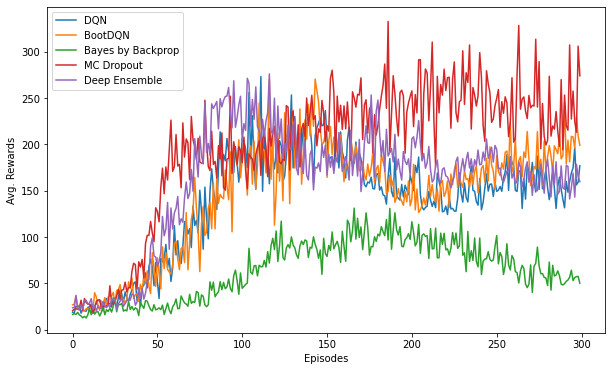

In [173]:
plt.figure(figsize=(10, 6))
plt.plot(np.asarray(Simple_reward).mean(0), label='DQN')
plt.plot(np.asarray(Boot_reward).mean(0), label='BootDQN')
plt.plot(np.asarray(B3_reward).mean(0), label='Bayes by Backprop')
plt.plot(np.asarray(Drop_reward).mean(0), label='MC Dropout')
plt.plot(np.asarray(En_reward).mean(0), label='Deep Ensemble')
plt.xlabel('Episodes')
plt.ylabel('Avg. Rewards')
plt.legend()
plt.show()

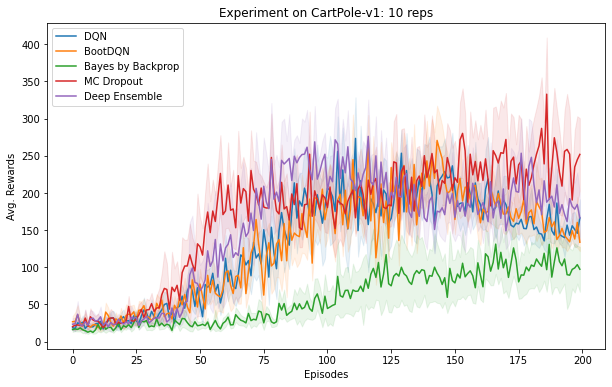

In [238]:
savedir = 'rst'

arr_Simple_rwd = np.asarray(Simple_reward)
arr_B3_rwd = np.asarray(B3_reward)
arr_Drop_rwd = np.asarray(Drop_reward)
arr_En_rwd = np.asarray(En_reward)
arr_Boot_rwd = np.asarray(Boot_reward)

np.save(os.path.join(savedir, 'Simple_rwd'), arr_Simple_rwd)
np.save(os.path.join(savedir, 'B3_rwd'), arr_B3_rwd)
np.save(os.path.join(savedir, 'Drop_rwd'), arr_Drop_rwd)
np.save(os.path.join(savedir, 'En_rwd'), arr_En_rwd)
np.save(os.path.join(savedir, 'Boot_rwd'), arr_Boot_rwd)

plt.figure(figsize=(10, 6))
idx = np.arange(arr_Simple_rwd.shape[1])[:200]

simple_mean = arr_Simple_rwd.mean(0)[:200]
simple_std = arr_Simple_rwd.std(0)[:200]
plt.plot(idx, simple_mean, color='C0', label='DQN')
plt.fill_between(idx, simple_mean+0.5*simple_std, simple_mean-0.5*simple_std,
                 color='C0', alpha=0.1)

Boot_mean = arr_Boot_rwd.mean(0)[:200]
Boot_std = arr_Boot_rwd.std(0)[:200]
plt.plot(idx, Boot_mean, color='C1', label='BootDQN')
plt.fill_between(idx, Boot_mean+0.5*Boot_std, Boot_mean-0.5*Boot_std,
                 color='C1', alpha=0.1)

B3_mean = arr_B3_rwd.mean(0)[:200]
B3_std = arr_B3_rwd.std(0)[:200]
plt.plot(idx, B3_mean, color='C2', label='Bayes by Backprop')
plt.fill_between(idx, B3_mean+0.5*B3_std, B3_mean-0.5*B3_std,
                 color='C2', alpha=0.1)

Drop_mean = arr_Drop_rwd.mean(0)[:200]
Drop_std = arr_Drop_rwd.std(0)[:200]
plt.plot(idx, Drop_mean, color='C3', label='MC Dropout')
plt.fill_between(idx, Drop_mean+0.5*Drop_std, Drop_mean-0.5*Drop_std,
                 color='C3', alpha=0.1)

En_mean = arr_En_rwd.mean(0)[:200]
En_std = arr_En_rwd.std(0)[:200]
plt.plot(idx, En_mean, color='C4', label='Deep Ensemble')
plt.fill_between(idx, En_mean+0.5*En_std, En_mean-0.5*En_std,
                 color='C4', alpha=0.1)

plt.xlabel('Episodes')
plt.ylabel('Avg. Rewards')
plt.title('Experiment on CartPole-v1: 10 reps')
plt.legend()
plt.savefig(os.path.join(savedir, 'plot2.png'))
plt.show()

In [300]:
agent_name = 'DQN'
model_save_dir = os.path.join(model_dir, agent_name)
if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

In [317]:
arr = np.asarray(B3_reward)
np.save(os.path.join(save_dir, agent_name), arr)
rst_dict[agent_name] = arr

In [318]:
arr.shape

(4, 210)